In [1]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from resnet20 import ResNetCIFAR
from train_util import train, finetune_after_prune, test
from scipy.interpolate import interp1d
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class Generator_Large(nn.Module):
    def __init__(self):
        super(Generator_Large, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(110,768),
            nn.ReLU())
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(768, 384, 5, 2),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(384, 192, 5, 2),
            nn.BatchNorm2d(192),
            nn.ReLU())
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(192, 96, 4, 2),
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.tconv4 = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, 1),
            nn.BatchNorm2d(48),
            nn.ReLU())
        self.tconv5 = nn.Sequential(
            nn.ConvTranspose2d(48, 3, 4, 2),
            nn.Tanh())
        self._initialize_weights()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.tconv1(out[:,:,None,None])
        out = self.tconv2(out)
        out = self.tconv3(out)
        out = self.tconv4(out)
        out = self.tconv5(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [3]:
class Generator_Original(nn.Module):
    def __init__(self):
        super(Generator_Original, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(110,384),
            nn.ReLU())
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(384, 192, 6, 2),
            nn.BatchNorm2d(192),
            nn.ReLU())
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(192, 96, 5, 2),
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(96, 3, 4, 2),
            nn.Tanh())
        self._initialize_weights()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.tconv1(out[:,:,None,None])
        out = self.tconv2(out)
        out = self.tconv3(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [4]:
generator_original = Generator_Original().to(device)
generator160_small = Generator_Original().to(device)
generator100_large = Generator_Large().to(device)
generator120_large = Generator_Large().to(device)

In [5]:
generator_original.load_state_dict(torch.load("generator100_original.pt"))
generator160_small.load_state_dict(torch.load("generator160_small.pt"))
generator100_large.load_state_dict(torch.load("generator100_large.pt"))
generator120_large.load_state_dict(torch.load("generator120_large.pt"))

generator_original.eval()
generator160_small.eval()
generator100_large.eval()
generator120_large.eval();

In [6]:
def reverse_norm_fake_image(img):
    return img*0.5 + 0.5

def norm_orig_image(img):
    return (img - torch.tensor([0.4914, 0.4822, 0.4465])[None,:,None,None])/torch.tensor([0.2023, 0.1994, 0.2010])[None,:,None,None]

In [7]:
fake_targets = np.repeat(np.arange(10), 5)
gen_input_np = np.c_[np.random.randn(50, 100), np.eye(10)[fake_targets]]
gen_input = torch.from_numpy(gen_input_np).float().to(device)
sample_images_original = reverse_norm_fake_image(generator_original(gen_input.detach()).detach().cpu())
sample_images_160_small = reverse_norm_fake_image(generator160_small(gen_input.detach()).detach().cpu())
sample_images_100_large = reverse_norm_fake_image(generator100_large(gen_input.detach()).detach().cpu())
sample_images_120_large = reverse_norm_fake_image(generator120_large(gen_input.detach()).detach().cpu())
sample_images = [sample_images_original, sample_images_160_small, sample_images_100_large, sample_images_120_large]

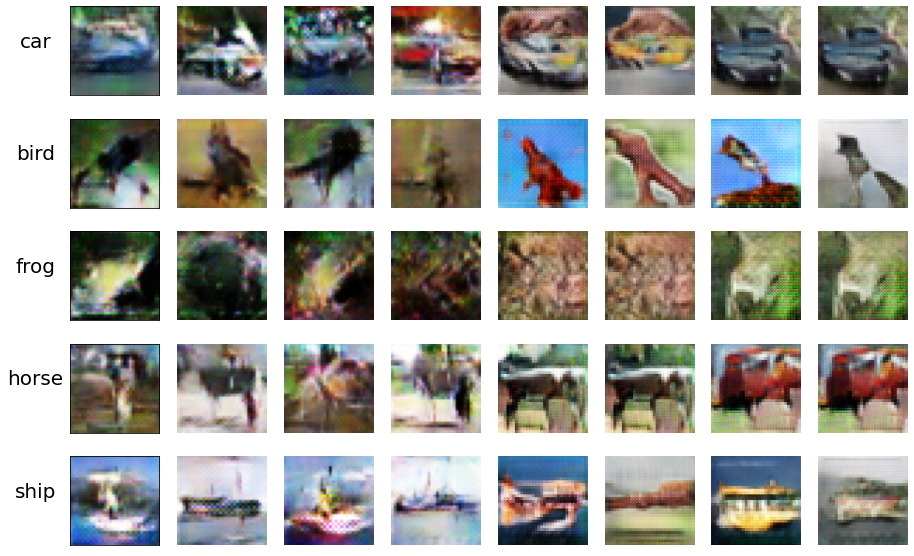

In [8]:
num_images_per_generator = 2
selected_classes = [1,2,6,7,8]
fig, axes = plt.subplots(len(selected_classes), num_images_per_generator*len(sample_images), figsize = (15, 10))
plt.axis("off")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(len(selected_classes)):
    for j in range(num_images_per_generator):
        for k in range(len(sample_images)):
            axes[i,k*num_images_per_generator+j].imshow(sample_images[k][5*selected_classes[i]+j].permute(1, 2, 0))
            if k*num_images_per_generator+j != 0:
                axes[i,k*num_images_per_generator+j].axis("off")
            else:
                axes[i,k*num_images_per_generator+j].set_xticks([])
                axes[i,k*num_images_per_generator+j].set_yticks([])
                axes[i,k*num_images_per_generator+j].set_ylabel(classes[fake_targets[5*selected_classes[i]+j]], rotation = 0, fontsize=20, labelpad= 35)

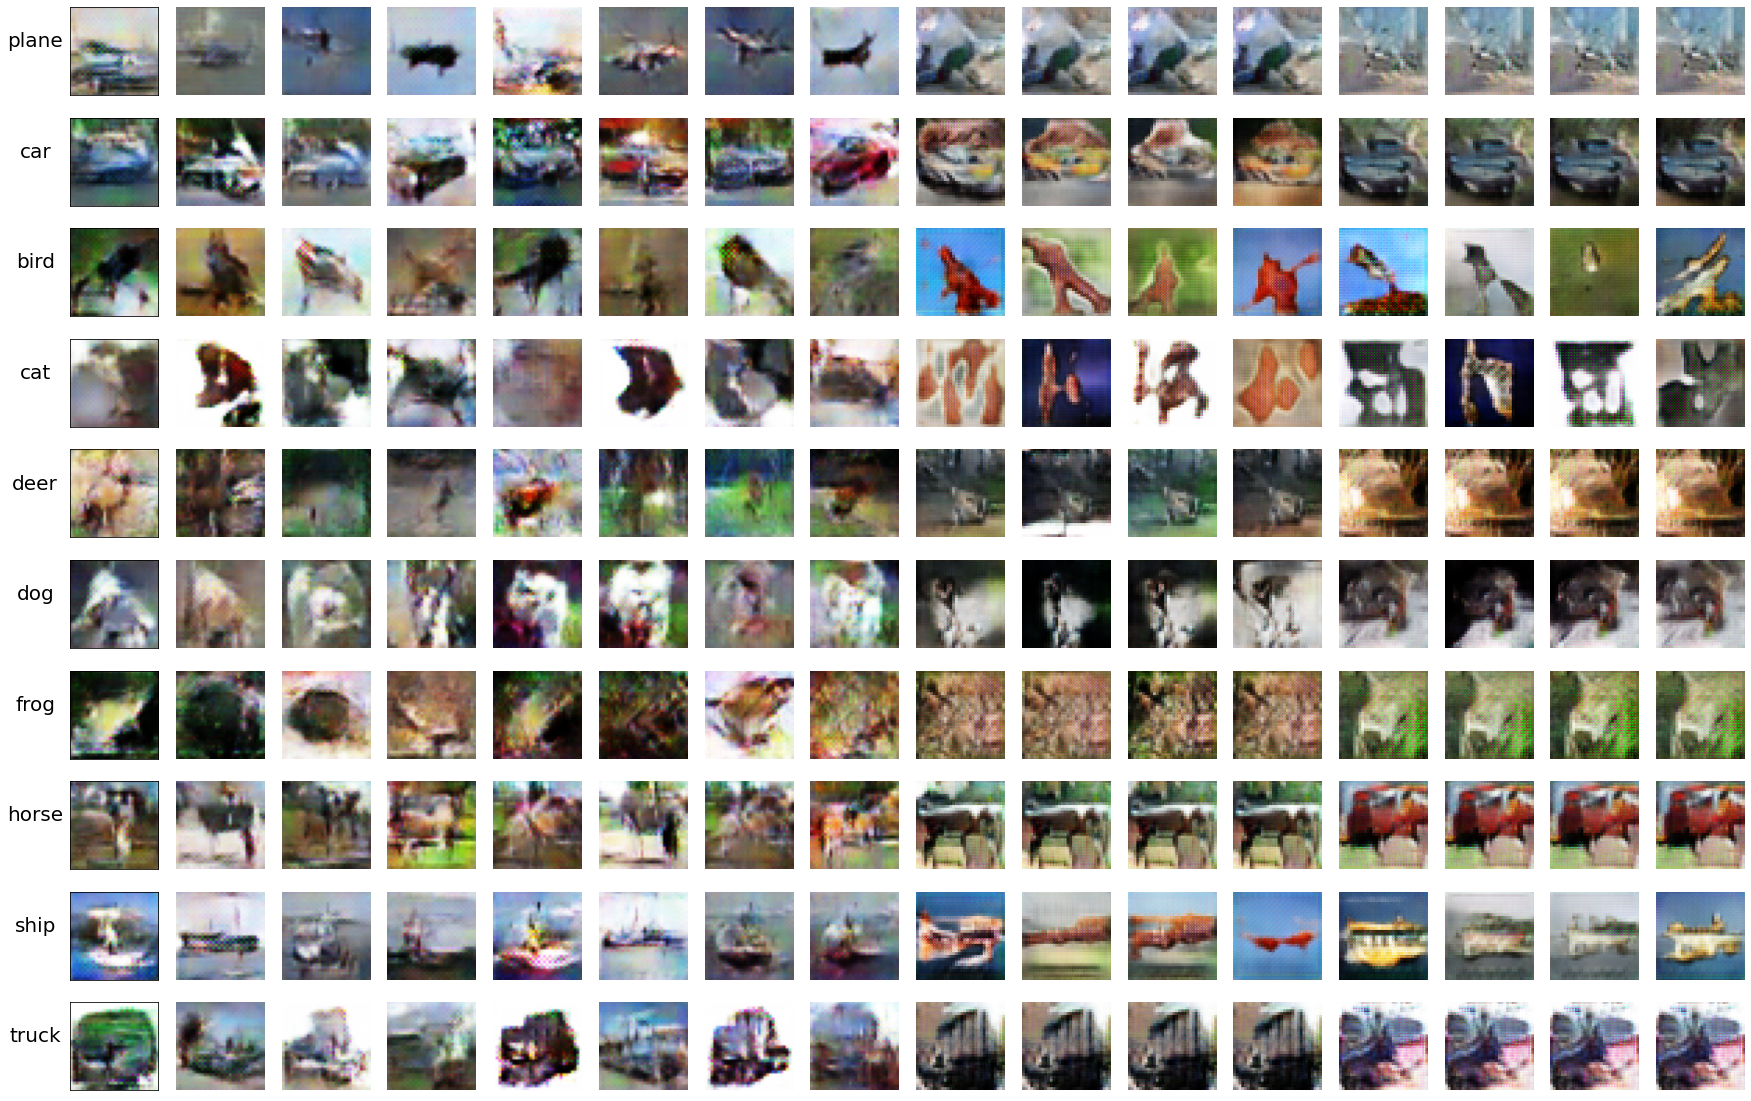

In [9]:
num_images_per_generator = 4
selected_classes = np.arange(10)
fig, axes = plt.subplots(len(selected_classes), num_images_per_generator*len(sample_images), figsize = (30, 20))
plt.axis("off")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(len(selected_classes)):
    for j in range(num_images_per_generator):
        for k in range(len(sample_images)):
            axes[i,k*num_images_per_generator+j].imshow(sample_images[k][5*selected_classes[i]+j].permute(1, 2, 0))
            if k*num_images_per_generator+j != 0:
                axes[i,k*num_images_per_generator+j].axis("off")
            else:
                axes[i,k*num_images_per_generator+j].set_xticks([])
                axes[i,k*num_images_per_generator+j].set_yticks([])
                axes[i,k*num_images_per_generator+j].set_ylabel(classes[fake_targets[5*selected_classes[i]+j]], rotation = 0, fontsize=20, labelpad= 35)

# Quantitative Metrics

In [10]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)

In [11]:
net.load_state_dict(torch.load("net_before_pruning.pt"))

<All keys matched successfully>

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
def calculate_inception_score(preds, splits = 10):
    preds = np.exp(preds)
    preds /= preds.sum(axis = 1)[:, None]
    scores = []
    for i in range(splits):
        split = preds[i*preds.shape[0]//splits : (i+1)*preds.shape[0]//splits, :]
        kl = split*(np.log(split) - np.log(np.mean(split, axis = 0)))
        scores.append(np.exp(np.mean(np.sum(kl, 1))))
    return np.mean(scores), np.std(scores)

In [14]:
def get_statistics(dataloader):
    net.eval()
    preds = np.empty((0,10))
    all_targets = np.empty((0,100))
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if torch.is_tensor(targets):
            targets = targets.detach().numpy()
        if inputs.shape[-1] == 32:
            inputs = inputs.to(device)
        else:
            inputs = nn.functional.upsample(inputs, size = 32, mode = "bilinear").to(device)
        all_targets = np.r_[all_targets, targets[None, :]]
        output = net(inputs)
        preds = np.r_[preds, output.detach().cpu().numpy()]
    print("Accuracy: {}%".format(100*np.round(np.mean(np.argmax(preds, axis = 1) == all_targets.flatten()),4)))
    print("Inception Score: {} \u00B1 {}".format(*np.round(calculate_inception_score(preds), 2)))

In [15]:
print("Statistics on Train Data:")
get_statistics(trainloader)

Statistics on Train Data:
Accuracy: 98.53%
Inception Score: 9.05 ± 0.03


In [16]:
print("Statistics on Test Data:")
get_statistics(testloader)

Statistics on Test Data:
Accuracy: 92.06%
Inception Score: 8.49 ± 0.1


In [17]:
fakes_original = []
fakes_160_small = []
fakes_100_large = []
fakes_120_large = []
num_images = 100
for i in range(250):
    fake_targets = np.random.randint(0, 10, num_images)
    gen_input_np = np.c_[np.random.randn(num_images, 100), np.eye(10)[fake_targets]]
    gen_input = torch.from_numpy(gen_input_np).float().to(device)
    fakes_original.append((norm_orig_image(reverse_norm_fake_image(generator_original(gen_input).detach().cpu())), fake_targets))
    fakes_160_small.append((norm_orig_image(reverse_norm_fake_image(generator160_small(gen_input).detach().cpu())), fake_targets))
    fakes_100_large.append((norm_orig_image(reverse_norm_fake_image(generator100_large(gen_input).detach().cpu())), fake_targets))
    fakes_120_large.append((norm_orig_image(reverse_norm_fake_image(generator120_large(gen_input).detach().cpu())), fake_targets))

In [18]:
print("Statistics on Original Model:")
get_statistics(fakes_original)
print("\nStatistics on Original Model, Finetuned:")
get_statistics(fakes_160_small)
print("\nStatistics on Large Model:")
get_statistics(fakes_100_large)
print("\nStatistics on Large Model, Finetuned:")
get_statistics(fakes_120_large)

Statistics on Original Model:
Accuracy: 46.27%
Inception Score: 4.12 ± 0.02

Statistics on Original Model, Finetuned:
Accuracy: 63.519999999999996%
Inception Score: 4.99 ± 0.04

Statistics on Large Model:


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Accuracy: 59.699999999999996%
Inception Score: 4.98 ± 0.05

Statistics on Large Model, Finetuned:
Accuracy: 90.82000000000001%
Inception Score: 7.11 ± 0.04


# Interpolation

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
def interpolate_between_classes(class1, class2, generator):
    linfit = interp1d([1,8], np.eye(10)[[class1,class2]], axis=0)
    labels = linfit([1, 3, 3.6, 4.2, 4.8, 5.4, 6, 8])
    random = np.tile(np.random.randn(1, 100)*1.4, 8).reshape((8,-1))
    gen_input_np = np.c_[random, labels]
    gen_input = torch.from_numpy(gen_input_np).float().to(device)
    fake_inputs = nn.functional.interpolate(reverse_norm_fake_image(generator(gen_input)), size = 32, mode = "bilinear").detach().cpu()
    #fake_inputs = reverse_norm_fake_image(generator(gen_input)).detach().cpu()
    fig, axes = plt.subplots(1,8, figsize = (20, 20))
    for j in range(8):
        axes[j].imshow(fake_inputs[j].permute(1, 2, 0))
        axes[j].axis("off")
    axes[0].set_title(classes[class1])
    axes[-1].set_title(classes[class2])
    plt.show()

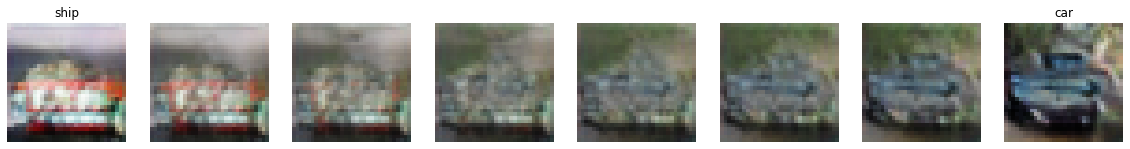

In [21]:
interpolate_between_classes(8,1,generator120_large)

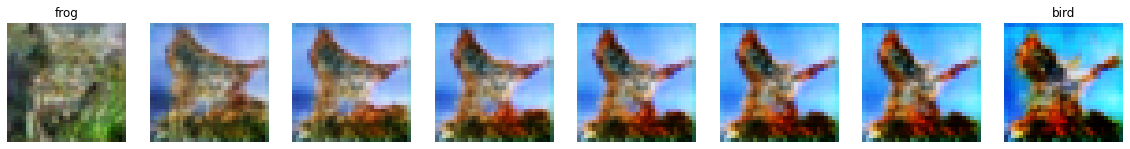

In [22]:
interpolate_between_classes(6,2,generator120_large)

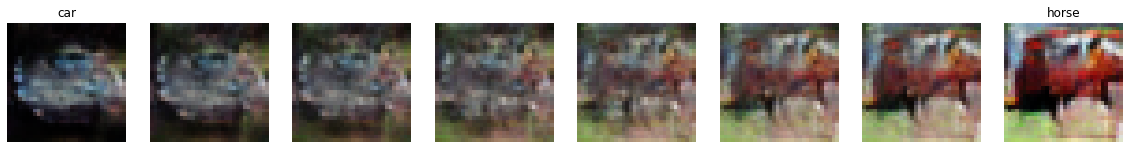

In [23]:
interpolate_between_classes(1,7,generator120_large)

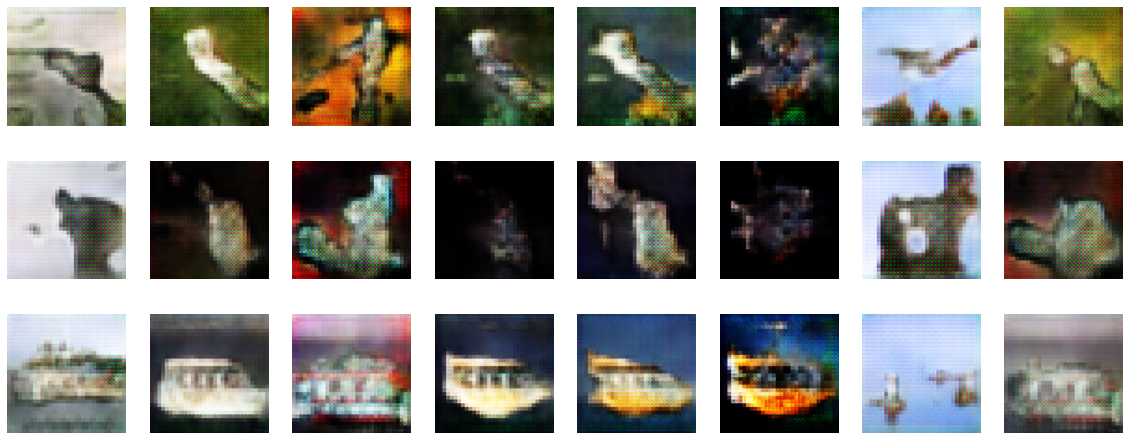

In [24]:
fake_targets = np.tile([2, 3, 8], 8)
gen_input_np = np.c_[np.repeat(np.random.randn(8, 100)*1.4, 3, axis = 0), np.eye(10)[fake_targets]]
gen_input = torch.from_numpy(gen_input_np).float().to(device)
samples = reverse_norm_fake_image(generator120_large(gen_input.detach()).detach().cpu())
fig, axes = plt.subplots(3, 8, figsize = (20, 8))
for j in range(8):
    for i in range(3):
        axes[i,j].imshow(samples[j*3 + i].permute(1, 2, 0))
        axes[i,j].axis("off")

# Extra Figures

In [25]:
data_original = np.array(pd.read_csv("data_original.csv", index_col = 0)["0"]).reshape(12, -1)[[0,1,4,5,8],]
data_large = np.array(pd.read_csv("data_large.csv", index_col = 0)["0"]).reshape(12, -1)[[0,1,4,5,8],]

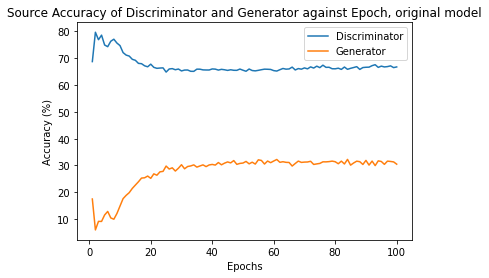

In [26]:
plt.plot(np.arange(1,101), (data_original[0] + data_original[2])/2, label = "Discriminator")
plt.plot(np.arange(1,101), data_original[4], label = "Generator")
plt.title("Source Accuracy of Discriminator and Generator against Epoch, original model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend();

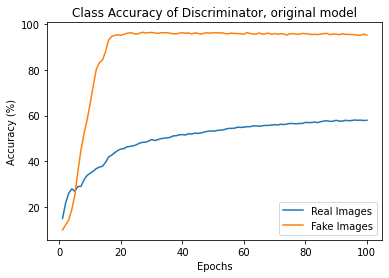

In [27]:
plt.plot(np.arange(1,101), data_original[1], label = "Real Images")
plt.plot(np.arange(1,101), data_original[3], label = "Fake Images")
plt.title("Class Accuracy of Discriminator, original model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend();

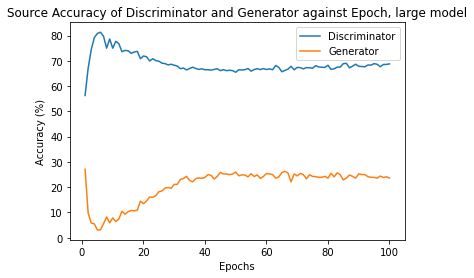

In [28]:
plt.plot(np.arange(1,101), (data_large[0] + data_large[2])/2, label = "Discriminator")
plt.plot(np.arange(1,101), data_large[4], label = "Generator")
plt.title("Source Accuracy of Discriminator and Generator against Epoch, large model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend();

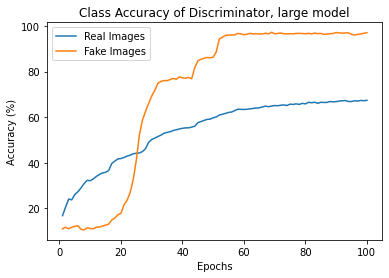

In [29]:
plt.plot(np.arange(1,101), data_large[1], label = "Real Images")
plt.plot(np.arange(1,101), data_large[3], label = "Fake Images")
plt.title("Class Accuracy of Discriminator, large model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend();